In [1]:
import numpy as np
from PIL import Image

class Grid:

    def __init__(self, 
        locations = dict(),
        N=10):
        
        self.B = 3 
        self.color = [0.2588, 0.4039, 0.6980]
        self.brightness = 1.8
        self.grid = []
        self.P = 5
        self.W = 100 
        self.M = N 
        self.N = N
        self.ew = self.W + self.P//2

        self.locations = locations
        self.icons = dict()
        for i in self.locations:
            self.icons[i] = self.load_image(f"images/{i}.png")

        self.grid = self.generate_grid()
        
    def load_image(self, path):
        image = Image.open(path)
        image = image.resize((self.W, self.W))
        image = np.array(image).astype('float') / 255
        return image
        
    def get_real_coordinates(self, i, j):

        x = j
        y = self.N - 1 - i
        return (x, y)
    
    def put_icon(self, grid, icon):

        gg = icon[:, :, 3:] * icon[:, :, :3]
        grid[self.P//2:-1*self.P//2, self.P//2:-1*self.P//2] = gg + (1 - icon[:, :, 3:]) * grid[self.P//2:-1*self.P//2, self.P//2:-1*self.P//2]
        return grid

    def generate_grid(self):
        grid = []

        # Iterate over each grid cell
        for i in range(self.M):
            
            # The row
            row_i = []

            # For each row
            for j in range(self.N):
                
                # The i and j-th grid cell
                grid_ij = np.ones((self.W + self.P, self.W + self.P, 3))

                # Paint with colors  
                for c in range(3):
                    grid_ij[:, :, c] = self.color[c] * (0.7 + (self.brightness - 0.9) / 60 * (i + 30 - j))

                # See if any icon should be here
                real_coordinates = self.get_real_coordinates(i, j)
                for k in self.locations:
                    if real_coordinates in self.locations[k]:
                        grid_ij = self.put_icon(grid_ij, self.icons[k])
                 
                # Make white
                grid_ij[:self.P//2, :, :] = 0
                grid_ij[-self.P//2:, :, :] = 0

                grid_ij[:, :self.P//2, :] = 0
                grid_ij[:, -self.P//2:, :] = 0
                
                # Append to row_i
                row_i.append(grid_ij)
        
            # Append to grid
            grid.append(row_i)
        return grid

    def get_grid(self, x, y):
        grid = self.grid[self.M - y - 1][x]
        return grid 

    def draw_one_step_grid(self, sp, dp, grid, color):
        if sp[0] == dp[0]:
            grid[sp[0]-self.P//2:dp[0] + self.P//2, sp[1]:dp[1], :] *= 0
            for c in range(3):
                grid[sp[0]-self.P//2:dp[0] + self.P//2, sp[1]:dp[1], c] = color[c]
        else:
            grid[sp[0]:dp[0], sp[1]-self.P//2:dp[1] + self.P//2, :] *= 0
            for c in range(3):
                grid[sp[0]:dp[0], sp[1]-self.P//2:dp[1] + self.P//2, c] = color[c]
        
    def draw_one_step(self, sp, dp, color):

        delta_x = dp[0] - sp[0] 
        delta_y = dp[1] - sp[1]
        
        sgrid = self.get_grid(sp[0] - 1, sp[1] - 1) 
        dgrid = self.get_grid(dp[0] - 1, dp[1] - 1)
        if delta_x == delta_y:
            return
        if delta_x == -1:
            self.draw_one_step_grid((self.ew // 2 + 1, 0), (self.ew // 2 + 1, self.ew // 2 + 1), sgrid, color)
            self.draw_one_step_grid((self.ew // 2 + 1, self.ew // 2 + 1), (self.ew // 2 + 1, self.W + self.P), dgrid, color)
            
        elif delta_x == 1:
            self.draw_one_step_grid((self.ew // 2 + 1, 0), (self.ew // 2 + 1, self.ew // 2 + 1), dgrid, color)
            self.draw_one_step_grid((self.ew // 2 + 1, self.ew // 2 + 1), (self.ew // 2 + 1, self.W + self.P), sgrid, color)
        elif delta_y == -1:
            self.draw_one_step_grid((0, self.ew // 2 + 1), (self.ew // 2 + 1, self.ew // 2 + 1), dgrid, color)
            self.draw_one_step_grid((self.ew // 2 + 1, self.ew // 2 + 1), (self.W + self.P, self.ew // 2 + 1), sgrid, color)
            
        elif delta_y == 1:
            self.draw_one_step_grid((0, self.ew // 2 + 1), (self.ew // 2 + 1, self.ew // 2 + 1), sgrid, color)
            self.draw_one_step_grid((self.ew // 2 + 1, self.ew // 2 + 1), (self.W + self.P, self.ew // 2 + 1), dgrid, color)
            
        return

    def draw_path(self, sequence, color = [0, 0, 1]):

        start_x, start_y = sequence[0]
        start_grid = self.get_grid(start_x - 1, start_y - 1)
        start_grid[self.P // 2:-1 * self.P // 2, self.P // 2:-1 * self.P // 2] *= 0
        start_grid[self.P // 2:-1 * self.P // 2, self.P // 2:-1 * self.P // 2, 0] += 1
        

        end_x, end_y = sequence[-1]
        end_grid = self.get_grid(end_x - 1, end_y - 1)
        end_grid[self.P // 2:-1 * self.P // 2, self.P // 2:-1 * self.P // 2] *= 0
        end_grid[self.P // 2:-1 * self.P // 2, self.P // 2:-1 * self.P // 2, 1] += 1
        
        for i in range(1, len(sequence)):
            self.draw_one_step(sequence[i - 1], sequence[i], color)
    
    def show(self, path = "demo.png", return_image = False):

        grid = [np.concatenate(row_i, axis = 1) for row_i in self.grid]
        grid = np.concatenate(grid, axis = 0)
        grid = np.clip(grid, 0, 1)
        grid_big = np.zeros((grid.shape[0] + 2 * self.B, grid.shape[1] + 2 * self.B, 3))
        grid_big[:, :, 0] = 1
        grid_big[:, :, 1] = 1
        grid_big[self.B:-1 * self.B, self.B:-1 * self.B] = grid

        grid = (grid_big * 255).astype('uint8')
        if return_image:
            return grid
        grid = Image.fromarray(grid)
        grid.save(path)
    
    def clear(self):
        self.grid = self.generate_grid()


In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pdb 
#from grid import Grid 
from PIL import Image
import imageio
from tqdm import tqdm



UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3

class TreasureHunt(gym.Env):

    def __init__(self, locations):
        
        self.locations = locations

        #the grid size
        self.n = 10
        self.num_treasures = len(self.locations['treasure'])
        self.num_states = self.n*self.n*(2**self.num_treasures)
        self.num_actions = 4
        self._action_delta = [[0,1],[0,-1],[-1,0],[1,0]]
        self.action_name = ['up','down','left','right']

        #the observation and action space
        self.observation_space = spaces.Discrete(self.num_states)
        self.action_space = spaces.Discrete(self.num_actions)

        #the 0th state
        self.state = 0

        #the treasure indicator
        self.treasure_from_index, self.index_from_treasure = self._get_treasure_indicator()

        #get transition matrix
        self.T = self._generate_tmatrix()

        #the reward matrix
        self.reward = self._generate_reward()
    
    def reset(self,seed = None, options = None):
        #self.state = (2**self.num_treasures - 1) * self.n * self.n
        self.state = 0
        if seed is not None:
            np.random.seed(seed)
        return self.state , {}
    
    def locations_from_state(self, state):
        
        treasure_index = state // 100
        treasure_indicator = self.treasure_from_index[treasure_index]
        treasure_locations = []
        for i in range(self.num_treasures):
            if(treasure_indicator[i] == '1'):
                treasure_locations.append(self.locations['treasure'][i])
        ship_location = state % 100
        ship_location = (ship_location // 10, ship_location % 10)
        return ship_location, treasure_locations 

    def _get_treasure_indicator(self):
        
        treasure_indicator = []
        treasure_index = dict()
        for n in range(2**self.num_treasures):
    
            treasure_indicator_n = bin(n)[2:][::-1]
            treasure_indicator_n = treasure_indicator_n + ''.join(['0' for i in range(self.num_treasures - len(treasure_indicator_n))])
            treasure_indicator.append(treasure_indicator_n)

            treasure_index[treasure_indicator_n] = n 
        return treasure_indicator, treasure_index

    
    def _get_pos_ts(self, x, y):

        out = np.arange(0, 2**self.num_treasures)
        if((x,y) in self.locations['treasure']):
            ind = self.locations['treasure'].index((x,y))
            for i in range(2**self.num_treasures):
                tind = self.treasure_from_index[i]
                if(tind[ind] == '1'):
                    tind = list(tind)
                    tind[ind] = '0'
                    tind = ''.join(tind)
                    out[i] = self.index_from_treasure[tind]
        return out

    def step(self, action):
        reward = self.reward[self.state]
        next_state = self.T[self.state, action]
        self.state = np.random.multinomial(1, next_state).nonzero()[0][0]
        return self.state, reward 
    
    def is_land(self, x, y):
        return ((x,y) in self.locations['land'])

    
    def _get_grid_locations(self, state_id):

        locations = dict()
        treasure_index = state_id // (self.n*self.n)
        state_id = state_id % (self.n*self.n)

        x, y = state_id // self.n, state_id % self.n 

        locations['pirate'] = self.locations['pirate']
        locations['fort'] = self.locations['fort']
        locations['ship'] = [(x,y)]
        locations['land'] = self.locations['land']
        locations['treasure'] = []
        treasure_indicator = self.treasure_from_index[treasure_index]
        for i in range(self.num_treasures):
            if((x,y) == self.locations['treasure'][i]):
                continue
            if(treasure_indicator[i] == '0'):
                continue
            locations['treasure'].append(self.locations['treasure'][i])
        return locations

    def render(self, state_id = None, path = 'state.jpeg', return_image = True):
        if(state_id is None):
            state_id = self.state
        locations = self._get_grid_locations(state_id)
        grid = Grid(locations)
        if(return_image):
            image = grid.show(return_image = True)
            return image

    def visualize_policy_execution(self, policy, path='output.gif'):
        # Start with the state where both treasures are present
        self.state = (2**self.num_treasures - 1) * self.n * self.n  # Full treasure state
        images = [self.render(return_image=True)]
    
        for i in tqdm(range(100)):
            action = np.argmax(policy[self.state])  # Use the policy to get the next action
            self.state, _ = self.step(action)
            images.append(self.render(return_image=True))
    
        # Save the trajectory as a GIF
        pil_images = [Image.fromarray(arr.astype('uint8')) for arr in images]
        imageio.mimsave(path, pil_images, duration=0.2)

    
    def get_policy_rewards(self, policy):
        self.state = (2**self.num_treasures - 1)*self.n*self.n
        rewards = []
        for i in range(100):
            action = np.argmax(policy[self.state])
            self.state, reward = self.step(action)
            rewards.append(reward)
        
        return np.array(rewards)
    

    def visualize_policy(self, policy, path = 'policy_vis.png'):

        state_id = (2**self.num_treasures - 1) * self.n * self.n  # Full treasure state
        policy_i = policy[state_id: state_id + self.n * self.n]
    
        # Get locations for visualization
        locations = self._get_grid_locations(state_id)
        del locations['ship']  # No need to show the ship separately
    
        #Get policy actions and visualize arrows
        policy_i = policy_i.argmax(-1).reshape(self.n, self.n)
        #policy_i = policy_i.reshape(self.n, self.n)
    
        for j in range(4):
            policy_ij = (policy_i == j).nonzero()
            policy_ij = [(x, y) for x, y in zip(policy_ij[0], policy_ij[1])]
            locations[f'{self.action_name[j]}_arrow'] = policy_ij
    
        # Create grid and save the visualization
        grid = Grid(locations)
        grid.show(path)


    def _generate_tmatrix(self):

        T = np.zeros((2**self.num_treasures, self.n, self.n, self.num_actions, 2**self.num_treasures, self.n, self.n))
        for x in range(self.n):
            for y in range(self.n):

                #if wall then ignore
                if(self.is_land(x,y)):
                    for i in range(2**self.num_treasures):
                        T[i,x,y,:,i,x,y] = 1
                    continue
                

                #it there is treasure at x,y then change the state
                pos_ts = self._get_pos_ts(x,y)

                #iterate over actions
                for a in range(4):

                    #the prob to distribute
                    prob = 1

                    #find the new state
                    nx = x + self._action_delta[a][0]
                    ny = y + self._action_delta[a][1]

                    #is valid?
                    if(nx < self.n and nx >= 0 and ny < self.n and ny >= 0):
                        if(not self.is_land(nx,ny)):
                            for i in range(2**self.num_treasures):
                                T[i,x,y,a,pos_ts[i],nx,ny] = 0.9
                            prob -= 0.9
                    

                    #now to distribute find all valid states
                    valid_states = [(x,y)]
                    for a_v in range(4):

                        #ignore the desired stated
                        if(a_v == a):
                            continue

                        nx = x + self._action_delta[a_v][0]
                        ny = y + self._action_delta[a_v][1]
                        #if valid append
                        if(nx < self.n and nx >= 0 and ny < self.n and ny >= 0):
                            if(self.is_land(nx,ny)):
                                continue
                            valid_states.append((nx, ny))
                    
                    #distribute the probability
                    for (nx,ny) in valid_states:
                        for i in range(2**self.num_treasures):
                            T[i,x,y,a,pos_ts[i],nx,ny] = prob / len(valid_states)

        T[:,self.n-1,self.n-1,:] = 0
        for i in range(2**self.num_treasures):
            T[i,self.n-1,self.n-1,:,i,self.n-1,self.n-1] = 1   

        T = T.reshape(self.num_states, 4, -1)
        return T
    
    def _generate_reward(self):

        reward = np.zeros((2**self.num_treasures,self.n,self.n)) - 0.1
        for i, tloc in enumerate(self.locations['treasure']):
            for j, tind in enumerate(self.treasure_from_index):
                if(tind[i] == '1'):
                    reward[j,tloc[0],tloc[1]] = 2
    
        for ploc in self.locations['pirate']:
            reward[:,ploc[0],ploc[1]] = -1
        
        floc = self.locations['fort'][0]
        reward[:,floc[0], floc[1]] = 0.01
        return reward.reshape(-1)

# locations = {
#     'ship': [(0,0)],
#     'land': [(3,0),(3,1),(3,2),(4,2),(4,1),(5,2),(0,7),(0,8),(0,9),(1,7),(1,8),(2,7)],
#     'fort': [(9,9)],
#     'pirate': [(4,7),(8,5)],
#     'treasure': [(4,0),(1,9)]
# }

# th = TreasureHunt(locations)
# T = th.T
# tt = T.sum(-1)
# pdb.set_trace()

# Policy Iteration

In [3]:
def policy_iteration(env, gamma=0.95, max_iterations=100):
     # Start with a uniform policy
    policy = np.ones([env.num_states, env.num_actions]) / env.num_actions 
    V = np.zeros(env.num_states)  
    
    for _ in range(max_iterations):
        # Policy evaluation step
        while True:
            delta = 0
            for s in range(env.num_states):
                v = V[s]
                V[s] = sum(policy[s, a] * (sum(env.T[s, a, s_next] * (env.reward[s] + gamma * V[s_next]) 
                                             for s_next in range(env.num_states))) 
                           for a in range(env.num_actions))
                delta = max(delta, abs(v - V[s]))
            if delta < 1e-5:
                break
        
        # Policy improvement step
        policy_stable = True
        for s in range(env.num_states):
            old_action = np.argmax(policy[s])
            policy[s] = np.eye(env.num_actions)[np.argmax([sum(env.T[s, a, s_next] * (env.reward[s] + gamma * V[s_next]) 
                                                               for s_next in range(env.num_states)) 
                                                           for a in range(env.num_actions)])]
            if old_action != np.argmax(policy[s]):
                policy_stable = False
        if policy_stable:
            break
    
    return policy, V

# Value Iteration

In [4]:
def value_iteration(env, gamma=0.95, max_iterations=100):
    V = np.zeros(env.num_states)
    policy = np.ones([env.num_states, env.num_actions]) / env.num_actions
    
    for _ in range(max_iterations):
        delta = 0
        for s in range(env.num_states):
            v = V[s]
            # Compute the expected return for each action and find the best action
            action_values = [sum(env.T[s, a, s_next] * (env.reward[s] + gamma * V[s_next]) 
                                 for s_next in range(env.num_states)) 
                             for a in range(env.num_actions)]
            V[s] = max(action_values)
            delta = max(delta, abs(v - V[s]))
        if delta < 1e-5:
            break
    
    # Derive policy from the value function
    for s in range(env.num_states):
        action_values = [sum(env.T[s, a, s_next] * (env.reward[s] + gamma * V[s_next]) 
                             for s_next in range(env.num_states)) 
                         for a in range(env.num_actions)]
        best_action = np.argmax(action_values)
        policy[s] = np.eye(env.num_actions)[best_action]
    
    return policy, V

In [41]:
# Assuming you have instantiated the environment
import time
locations = {
    'ship': [(0,0)],
    'land': [(3,0),(3,1),(3,2),(4,2),(4,1),(5,2),(0,7),(0,8),(0,9),(1,7),(1,8),(2,7)],
    'fort': [(9,9)],
    'pirate': [(4,7),(8,5)],
    'treasure': [(4,0),(1,9)]
}

env = TreasureHunt(locations)

# Run Policy Iteration
start = time.time()
policy1, V1 = policy_iteration(env)
env.visualize_policy(policy1, path="policy_iteration_visualization.png")
env.visualize_policy_execution(policy1, path="policy_trajectory.gif")
end = time.time()
print("Time taken: {}".format(end-start))

# Run Value Iteration
start = time.time()
policy2, V2 = value_iteration(env)
env.visualize_policy(policy2, path="value_iteration_visualization.png")
env.visualize_policy_execution(policy2, path="value_trajectory.gif")
end = time.time()
print("Time taken: {}".format(end-start))

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.93it/s]


Time taken: 160.89214277267456


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 16.63it/s]


Time taken: 48.594208002090454


# TreasureHunt-v1 environment

# SARSA

In [74]:
def choose_action(state, Q, epsilon, n_actions):
    #Choose action using epsilon-greedy policy.
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)
    return np.argmax(Q[state])

def sarsa(env, gamma=0.95, alpha=0.3, epsilon=0.4, max_episodes=1000):
    n_states = env.num_states
    n_actions = env.num_actions
    Q = np.zeros((n_states, n_actions))
    rewards_per_episode = []
    stable_policy_count = 0
    convergence_episodes = 7
    
    previous_policy = np.argmax(Q , axis = 1)
    
    for episode in tqdm(range(max_episodes)):
        state, _ = env.reset()
        action = choose_action(state, Q, epsilon, n_actions)
        Q_old = np.copy(Q)
        total_reward = 0

        i=0
        while True:
            next_state, reward = env.step(action)
            next_action = choose_action(next_state, Q, epsilon, n_actions)

            # SARSA update rule
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])

            state = next_state
            action = next_action
            total_reward += reward

            if state == env.n * env.n - 1:
                #print(f"Reached goal state at episode {episode}, step {i}, reward till then {total_reward}")
                break
            i += 1 
            
        rewards_per_episode.append(total_reward)
        
        current_policy = np.argmax(Q, axis=1)
        """
        max_q_change = np.abs(Q - Q_old).max()
        if max_q_change < 1e-3:
            stable_count += 1
        else:
            stable_count = 0"""
        
        if np.array_equal(current_policy, previous_policy):
            stable_policy_count += 1
        else:
            stable_policy_count = 0  

        previous_policy = current_policy

        if stable_policy_count >= convergence_episodes:
            print(f"Policy converged after {episode} episodes.")
            break

    policy = np.argmax(Q, axis=1)
    return Q, policy, rewards_per_episode

# Q-Learning

In [75]:
def q_learning(env, gamma=0.95, alpha=0.3, epsilon=0.4, max_episodes=1000):
    n_states = env.num_states
    n_actions = env.num_actions
    Q = np.zeros((n_states, n_actions))
    rewards_per_episode = []
    stable_policy_count = 0
    convergence_episodes = 8
    
    previous_policy = np.argmax(Q , axis = 1)
    
    for episode in tqdm(range(max_episodes)):
        state, _ = env.reset()
        total_reward = 0
        Q_old = np.copy(Q)
        i=0
        while True:
            action = choose_action(state, Q, epsilon, n_actions)
            next_state, reward = env.step(action)

            # Q-learning update rule
            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])

            state = next_state
            total_reward += reward

            if state == env.n * env.n - 1:
                break
            i += 1 

        rewards_per_episode.append(total_reward)
        
        current_policy = np.argmax(Q, axis=1)
        """
        max_q_change = np.abs(Q - Q_old).max()
        if max_q_change < 1e-3:
            stable_count += 1
        else:
            stable_count = 0"""
            
        if np.array_equal(current_policy, previous_policy):
            stable_policy_count += 1
        else:
            stable_policy_count = 0  # Reset if the policy changes

        previous_policy = current_policy

        if stable_policy_count >= convergence_episodes:
            print(f"Policy converged after {episode} episodes.")
            break

    policy = np.argmax(Q, axis=1)
    return Q, policy, rewards_per_episode

In [76]:
import torch
locations = {
    'ship': [(0,0)],
    'land': [(3,0),(3,1),(3,2),(4,2),(4,1),(5,2),(0,7),(0,8),(0,9),(1,7),(1,8),(2,7)],
    'fort': [(9,9)],
    'pirate': [(4,7),(8,5)],
    'treasure': [(4,0),(1,9)]
}

# Assuming you have the TreasureHunt environment ready
env = TreasureHunt(locations)

# Train SARSA
sarsa_q_table, sarsa_policy, sarsa_rewards= sarsa(env, gamma=0.95, alpha=0.3, epsilon=0.4, max_episodes=10000)
torch.save(sarsa_q_table, "sarsa_q_table_treasure.pt")
torch.save(sarsa_policy, "sarsa_policy_treasure.pt")

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1874.25it/s]


In [77]:
print("Now we do for Q-learning.")
# Train Q-Learning
q_table, q_policy, q_rewards = q_learning(env, gamma=0.95, alpha=0.3, epsilon=0.4, max_episodes=10000)
torch.save(q_table, "q_learning_q_table_treasure.pt")
torch.save(q_policy, "q_learning_policy_treasure.pt")

Now we do for Q-learning.


 28%|██████████▏                         | 2833/10000 [00:02<00:05, 1382.73it/s]

Policy converged after 2833 episodes.


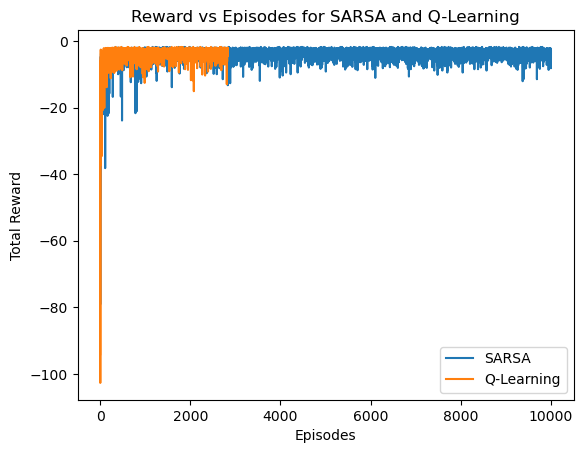

In [78]:
import matplotlib.pyplot as plt

plt.plot(sarsa_rewards, label='SARSA')
plt.plot(q_rewards, label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Reward vs Episodes for SARSA and Q-Learning')
plt.legend()
plt.savefig("reward vs ep part 2 plot.png")
plt.show()



For SARSA:
Results after 100 episodes:
Average reward per episode: -2.1090000000000004


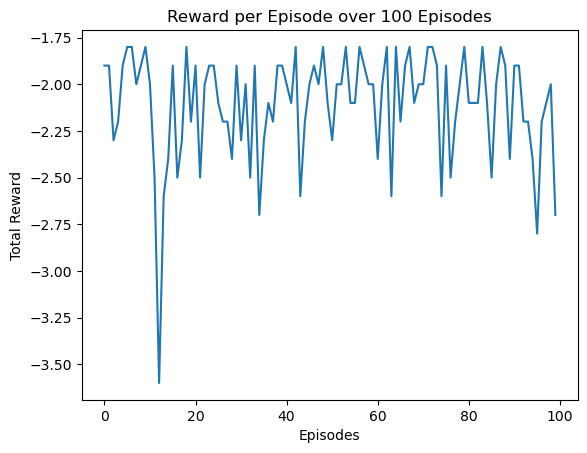

For Q-Learning
Results after 100 episodes:
Average reward per episode: -2.1050000000000004


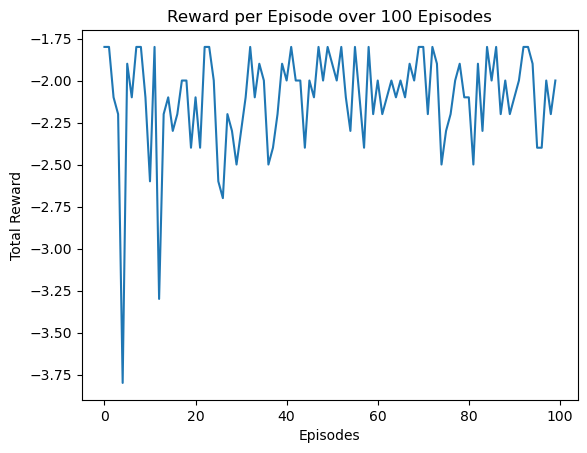

In [79]:
import torch
import random
import matplotlib.pyplot as plt
import moviepy.editor as mpy

def evaluate_policy(env, q_table, display_episodes=5, total_episodes=100, max_steps = 500):
    total_reward = 0
    total_steps = 0
    rewards_per_episode = []
    
    for i_episode in range(total_episodes):
        state, info = env.reset()
        rewards, steps = 0, 0

        while True:
            action = np.argmax(q_table[state]).item() 
            state, reward = env.step(action)
            steps += 1
            rewards += reward
            
            if state == env.n * env.n - 1:
                break
            
            if steps > max_steps:
                break
        
        rewards_per_episode.append(rewards)
        total_reward += rewards
    
    avg_reward = total_reward / total_episodes

    print(f"Results after {total_episodes} episodes:")
    print(f"Average reward per episode: {avg_reward}")

    # Plot the rewards per episode
    plt.plot(rewards_per_episode)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title(f'Reward per Episode over {total_episodes} Episodes')
    plt.show()

    return avg_reward

# Assuming the environment and Q-table are already defined
q_table_1 = torch.load("q_learning_q_table_treasure.pt")
q_table_2 = torch.load("sarsa_q_table_treasure.pt")

# Evaluate the Q-learning policy
print("For SARSA:")
avg_reward_sarsa = evaluate_policy(env, q_table_2, display_episodes=5, total_episodes=100, max_steps=500)
print("For Q-Learning")
avg_reward_qlearning = evaluate_policy(env, q_table_1, display_episodes=5, total_episodes=100, max_steps=500)

In [183]:
sarsa_policy = torch.load("sarsa_policy_treasure.pt")
sarsa_policy = np.array(sarsa_policy)
num_states = len(sarsa_policy)
num_actions = 4
policy = np.zeros((num_states , num_actions))
for s in range(num_states):
    action = sarsa_policy[s]
    policy[s, action] = 1.0
env.visualize_policy(policy, path="sarsa_treasure.png")
env.visualize_policy_execution(policy, path="sarsa_policy_treasure.gif")

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 18.17it/s]


In [160]:
q_policy = torch.load("q_learning_policy_treasure.pt")
q_policy = np.array(q_policy)
num_states = len(sarsa_policy)
num_actions = 4
policy = np.zeros((num_states , num_actions))
for s in range(num_states):
    action = sarsa_policy[s]
    policy[s, action] = 1.0
env.visualize_policy(policy, path="q_treasure.png")
env.visualize_policy_execution(policy, path="q_policy_treasure.gif")

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.93it/s]


# Taxi-v3 environment

In [80]:
# Action selection function (ε-greedy)
def choose_action(state, Q, epsilon, NActions):
    if random.uniform(0, 1) < epsilon:
        return random.choice(range(NActions))  
    else:
        return torch.argmax(Q[state]).item()  

# Extract policy from the Q-table
def extract_policy(Q, NActions):
    policy = torch.zeros(Q.shape[0], dtype=torch.long)
    for state in range(Q.shape[0]):
        policy[state] = torch.argmax(Q[state])
    return policy

# Epsilon decay function for Taxi-v3
def epsilon_decay_function(epsilon_start, decay_factor, episode, K, epsilon_end=0.1):
    return max(epsilon_start * (decay_factor ** (episode / K)), epsilon_end)

def plot_metrics(rewards, epsilons, title):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Rewards', color='tab:blue')
    ax1.plot(rewards, color='tab:blue', label="Rewards")
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Epsilon', color='tab:red')
    ax2.plot(epsilons, color='tab:red', label="Epsilon")
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title(title)
    fig.tight_layout()
    plt.show()

# SARSA

In [83]:
def sarsa(env, gamma=0.95, alpha=0.05, epsilon=0.4, MaxEpisodes=20000, epsilon_decay=None):
    NStates = env.observation_space.n
    NActions = env.action_space.n

    Q = torch.zeros([NStates, NActions])
    rewards_per_episode = []
    epsilons_per_episode = []
    stable_policy_count = 0
    convergence_episodes = 300
    max_steps = 500
    
    prev_policy = extract_policy(Q, NActions)
    
    for episode in tqdm(range(MaxEpisodes)):
        state = env.reset()  # Initial state
        state = 0
        action = choose_action(state, Q, epsilon, NActions)
        total_reward = 0
        
        done = False
        steps = 0
        while not done:
            next_state, reward,done,_,_ = env.step(action)
            next_action = choose_action(next_state, Q, epsilon, NActions)
            total_reward += reward
            steps += 1
            if steps >= max_steps:
                break

            # SARSA Q-value update rule
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])

            state = next_state
            action = next_action

        rewards_per_episode.append(total_reward)
        epsilons_per_episode.append(epsilon)

        if epsilon_decay:
            epsilon = epsilon_decay(epsilon, episode)

        #policy = extract_policy(Q, NActions)
        current_policy = extract_policy(Q, NActions)
        if torch.equal(current_policy , prev_policy):
            stable_policy_count += 1
        else:
            stable_policy_count = 0
            
        prev_policy = current_policy
        
        if stable_policy_count >= convergence_episodes:
            break
    
    policy = extract_policy(Q, NActions)
    return Q, policy, rewards_per_episode, epsilons_per_episode

# Q-Learning

In [84]:
def q_learning(env, gamma=0.95, alpha=0.05, epsilon=0.4, MaxEpisodes=20000, epsilon_decay=None):
    NStates = env.observation_space.n
    NActions = env.action_space.n

    Q = torch.zeros([NStates, NActions])
    rewards_per_episode = []
    epsilons_per_episode = []
    stable_policy_count = 0
    convergence_episodes = 300
    max_steps = 500
    
    prev_policy = extract_policy(Q, NActions)

    for episode in tqdm(range(MaxEpisodes)):
        state = env.reset()[0]  # Initial state
        total_reward = 0

        done = False
        steps = 0
        while not done:
            action = choose_action(state, Q, epsilon, NActions)
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            steps += 1
            if steps >= max_steps:
                break

            # Q-Learning Q-value update rule
            Q[state, action] += alpha * (reward + gamma * torch.max(Q[next_state]) - Q[state, action])

            state = next_state

        rewards_per_episode.append(total_reward)
        epsilons_per_episode.append(epsilon)

        if epsilon_decay:
            epsilon = epsilon_decay(epsilon, episode)
            
        current_policy = extract_policy(Q, NActions)
        if torch.equal(current_policy , prev_policy):
            stable_policy_count += 1
        else:
            stable_policy_count = 0
            
        prev_policy = current_policy
        
        #if stable_policy_count >= convergence_episodes:
         #   break

    policy = extract_policy(Q, NActions)
    return Q, policy, rewards_per_episode, epsilons_per_episode

100%|████████████████████████████████████| 10000/10000 [00:56<00:00, 175.75it/s]


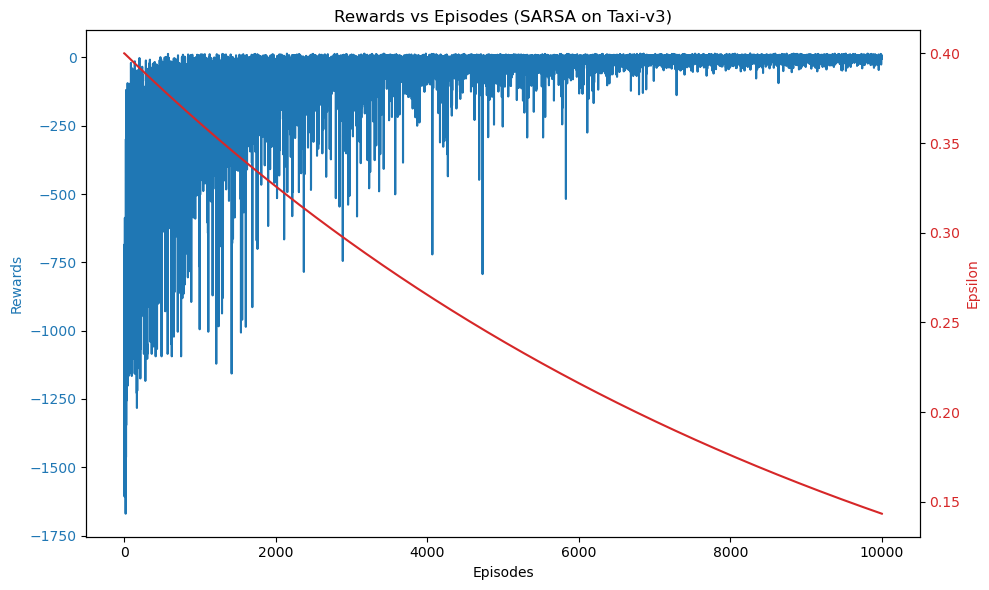

100%|████████████████████████████████████| 10000/10000 [00:53<00:00, 187.63it/s]


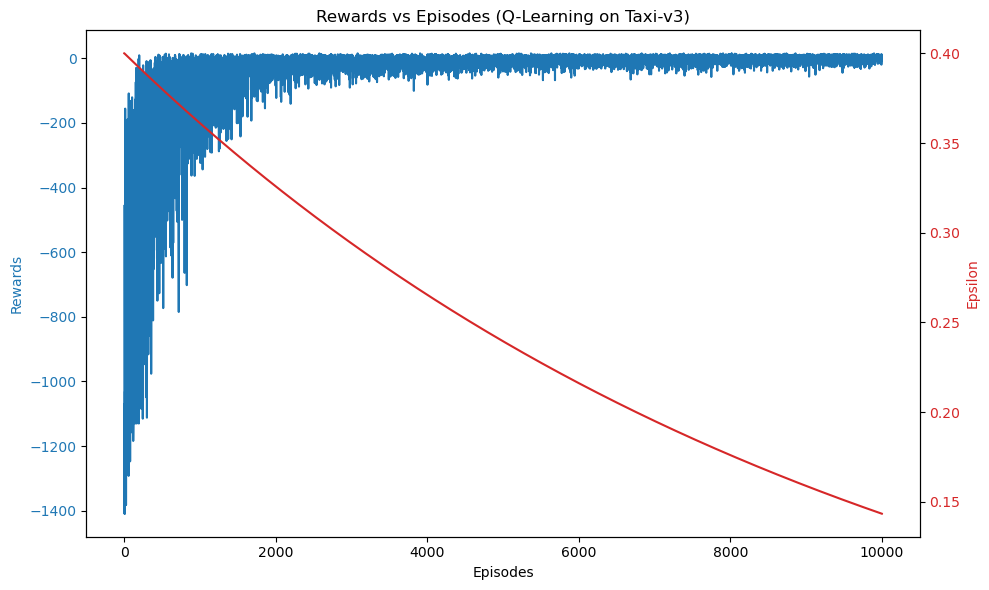

In [85]:
import torch
import random
import matplotlib.pyplot as plt
env2 = gym.make('Taxi-v3')

# Epsilon decay parameters
epsilon_start = 0.4
decay_factor = 0.95
K = 500

# Train SARSA on Taxi-v3 (with decaying epsilon)
sarsa_q_table2, sarsa_policy2, sarsa_rewards2, sarsa_epsilons2 = sarsa(
    env2, gamma=0.95, alpha=0.05, epsilon=epsilon_start, MaxEpisodes=10000,
    epsilon_decay=lambda eps, episode: epsilon_decay_function(epsilon_start, decay_factor, episode, K)
)
torch.save(sarsa_q_table2, "sarsa_q_table_taxi.pt")
torch.save(sarsa_policy2, "sarsa_policy_taxi.pt")
plot_metrics(sarsa_rewards2, sarsa_epsilons2, "Rewards vs Episodes (SARSA on Taxi-v3)")

# Train Q-Learning on Taxi-v3 (with decaying epsilon)
q_learning_q_table2, q_learning_policy2, q_learning_rewards2, q_learning_epsilons2 = q_learning(
    env2, gamma=0.95, alpha=0.05, epsilon=epsilon_start, MaxEpisodes=10000,
    epsilon_decay=lambda eps, episode: epsilon_decay_function(epsilon_start, decay_factor, episode, K)
)
torch.save(q_learning_q_table2, "q_learning_q_table_taxi.pt")
torch.save(q_learning_policy2, "q_learning_policy_taxi.pt")
plot_metrics(q_learning_rewards2, q_learning_epsilons2, "Rewards vs Episodes (Q-Learning on Taxi-v3)")

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

def run(episodes, render=False):

    env = gym.make('Taxi-v3', render_mode='human' if render else None)
    q = np.zeros((env.observation_space.n, env.action_space.n)) # init a 500 x 6 array
    learning_rate_a = 0.05
    discount_factor_g = 0.95 
    epsilon = 1           
    rng = np.random.default_rng() 

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]  # states: 0 to 63, 0=top left corner,63=bottom right corner
        terminated = False      # True when fall in hole or reached goal
        truncated = False       # True when actions > 200

        rewards = 0
        max_iter = 100
        itera = 0
        while(not terminated and not truncated):
            itera += 1
            if itera >= max_iter:
                break
            if rng.random() < epsilon:
                action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
            else:
                action = np.argmax(q[state,:])
            new_state,reward,terminated,truncated,_ = env.step(action)
            rewards += reward
            q[state,action] = q[state,action] + learning_rate_a * (
                reward + discount_factor_g * np.max(q[new_state,:]) - q[state,action]
            )
            state = new_state
        epsilon = max(pow(0.85 , (i / 100)) , 0.005)
        print("Episode: {} and reward: {}".format(i , rewards))
        rewards_per_episode[i] = rewards
    return q , rewards_per_episode

    env.close()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_rewards)
    plt.savefig('taxi.png')

if __name__ == '__main__':
    #run(15000)

    q , rewards = run(100, render=True)

Episode: 0 and reward: -378
Episode: 1 and reward: -441
Episode: 2 and reward: -387
Episode: 3 and reward: -342
Episode: 4 and reward: -396
Episode: 5 and reward: -342
Episode: 6 and reward: -468
Episode: 7 and reward: -432
Episode: 8 and reward: -360
Episode: 9 and reward: -387
Episode: 10 and reward: -387
Episode: 11 and reward: -342
Episode: 12 and reward: -387
Episode: 13 and reward: -378
Episode: 14 and reward: -324
Episode: 15 and reward: -459
Episode: 16 and reward: -459
Episode: 17 and reward: -405
Episode: 18 and reward: -342
Episode: 19 and reward: -414
Episode: 20 and reward: -405
Episode: 21 and reward: -405
Episode: 22 and reward: -414
Episode: 23 and reward: -378
Episode: 24 and reward: -441
Episode: 25 and reward: -342
Episode: 26 and reward: -441


KeyboardInterrupt: 

Results after 100 episodes:
Average reward per episode: -7.4


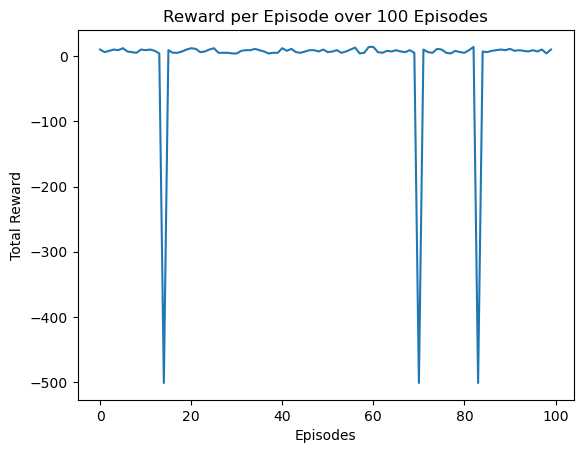

Results after 100 episodes:
Average reward per episode: 7.97


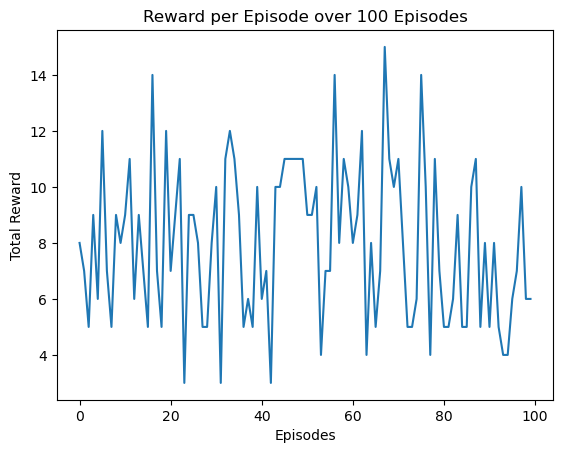

In [86]:
import torch
import random
import matplotlib.pyplot as plt
import moviepy.editor as mpy

def evaluate_policy(env, q_table, display_episodes=5, total_episodes=100, max_steps = 500):
    """Evaluate the learned Q-table policy over 100 episodes and report the mean reward."""
    total_reward = 0
    total_steps = 0
    rewards_per_episode = []
    
    for i_episode in range(total_episodes):
        state, info = env.reset()
        rewards, steps = 0, 0

        done = False
        while not done:
            action = np.argmax(q_table[state]).item()  
            state, reward,done,_,_ = env.step(action)
            steps += 1
            rewards += reward
            
            if steps > max_steps:
                break
        
        rewards_per_episode.append(rewards)
        total_reward += rewards
    
    # Compute average reward per episode
    avg_reward = total_reward / total_episodes

    print(f"Results after {total_episodes} episodes:")
    print(f"Average reward per episode: {avg_reward}")

    # Plot the rewards per episode
    plt.plot(rewards_per_episode)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title(f'Reward per Episode over {total_episodes} Episodes')
    plt.show()

    return avg_reward

# Assuming the environment and Q-table are already defined
q_table_1 = torch.load("sarsa_q_table_taxi.pt")
q_table_2 = torch.load("q_learning_q_table_taxi.pt")

# Evaluate the Q-learning policy
avg_reward_qlearning = evaluate_policy(env2, q_table_1, display_episodes=5, total_episodes=100, max_steps=500)
avg_reward_sarsa = evaluate_policy(env2, q_table_2, display_episodes=5, total_episodes=100, max_steps=500)



In [216]:
import torch
import numpy as np
q_table = torch.load('q_learning_q_table_taxi.pt')  # If saved to a file

env = gym.make('Taxi-v3', render_mode='human')
state = int(env.reset()[0])

terminated = False
truncated = False

while not (terminated or truncated):
    # Select the best action based on the learned policy (Q-table)
    action = int(np.argmax(q_table[state]))  # Replace with the learned action
    newstate, reward, terminated, truncated, _ = env.step(action)
    state = int(newstate)

env.close()

# LunarLander env DQN

In [87]:
__credits__ = ["Andrea PIERRÉ"]

import math
import sys
from typing import Optional

import numpy as np
import pygame
from pygame import gfxdraw

"""import Box2D
from Box2D.b2 import (
    edgeShape,
    circleShape,
    fixtureDef,
    polygonShape,
    revoluteJointDef,
    contactListener,
)"""

import gym
from gym import error, spaces
from gym.utils import seeding, EzPickle

FPS = 120
SCALE = 60.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  # Set 1500 to make game harder

LANDER_POLY = [(-14, +17), (-17, 0), (-17, -10), (+17, -10), (+17, 0), (+14, +17)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400


"""class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env

    def BeginContact(self, contact):
        if (
            self.env.lander == contact.fixtureA.body
            or self.env.lander == contact.fixtureB.body
        ):
            self.env.game_over = True
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = True

    def EndContact(self, contact):
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = False"""


class LunarLander(gym.Env, EzPickle):
    

    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": FPS}

    def __init__(self, continuous: bool = False):
        EzPickle.__init__(self)
        self.screen = None
        self.isopen = True
        self.gravity = np.array([0.0, -9.8])
        self.lander = None
        self.particles = []
        self.continuous = continuous

        # Observation and action spaces remain the same
        self.observation_space = spaces.Box(-np.inf, np.inf, shape=(8,), dtype=np.float32)

        if self.continuous:
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)
        else:
            self.action_space = spaces.Discrete(4)

    def _destroy(self):
        """Simplified destroy function."""
        self.lander = None
        self.particles = []


    def reset(self, seed = None):
        if seed is not None:
            self.np_random, seed = gym.utils.seeding.np_random(seed)
        self._destroy()
        self.game_over = False
        self.prev_shaping = None

        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE
        
        # Helipad position (define the x and y coordinates for the helipad)
        self.helipad_x1 = VIEWPORT_W / 2 - W / 6
        self.helipad_x2 = VIEWPORT_W / 2 + W / 6
        self.helipad_y = H / 4  # You can adjust this based on your desired helipad height

        # Initialize lander position
        initial_y = VIEWPORT_H / SCALE
        self.lander = {
            "position": np.array([VIEWPORT_W / 2, initial_y]),
            "velocity": np.array([0.0, 0.0]),
            "angle": 0.0,
            "angular_velocity": 0.0,
            "fuel": 100.0,
            "ground_contact": [False, False],
        }

        # Random forces to add a bit of complexity
        self.lander["velocity"] += self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM, size=2) / SCALE
        self.lander["angular_velocity"] += self.np_random.uniform(-1.0, 1.0)
        
        # Initialize sky polygons (simple rectangle for now)
        self.sky_polys = [
            [(0, 0), (W, 0), (W, H), (0, H)]  # Simple full background polygon
        ]
        
        self.drawlist = [self.lander]  # Add lander to drawlist
        self.legs = [{"position": np.array([0.0, 0.0]), "ground_contact": False},  # Example legs
                     {"position": np.array([0.0, 0.0]), "ground_contact": False}]
    
        self.drawlist += self.legs  # Add legs to the drawlist

        return np.array([0.0] * 8, dtype=np.float32)  # Simplified return for now


    def _create_particle(self, mass, x, y, ttl):
        p = self.world.CreateDynamicBody(
            position=(x, y),
            angle=0.0,
            fixtures=fixtureDef(
                #shape=circleShape(radius=2 / SCALE, pos=(0, 0)),
                shape = pygame.draw.circle(screen, (0, 0, 255), position.astype(int), radius),
                density=mass,
                friction=0.1,
                categoryBits=0x0100,
                maskBits=0x001,  # collide only with ground
                restitution=0.3,
            ),
        )
        p.ttl = ttl
        self.particles.append(p)
        self._clean_particles(False)
        return p

    def _clean_particles(self, all):
        while self.particles and (all or self.particles[0].ttl < 0):
            self.world.DestroyBody(self.particles.pop(0))

    def step(self, action):
        # Ensure action is within bounds
        if self.continuous:
            action = np.clip(action, -1, 1)
        else:
            assert self.action_space.contains(action), "Invalid action"

        # Physics update (simplified)
        main_engine_force = 0.0
        side_engine_force = 0.0

        # Main engine control
        if (self.continuous and action > 0) or (not self.continuous and action == 2):
            main_engine_force = MAIN_ENGINE_POWER * action if self.continuous else MAIN_ENGINE_POWER
            self.lander["fuel"] -= main_engine_force * 0.1

        # Side engines
        if (self.continuous and abs(action) > 0.5) or (not self.continuous and action in [1, 3]):
            side_engine_force = SIDE_ENGINE_POWER * action if self.continuous else SIDE_ENGINE_POWER * (action - 2)
            self.lander["fuel"] -= abs(side_engine_force) * 0.1

        # Update velocity and position (simple physics)
        self.lander["velocity"] += self.gravity / FPS + np.array([side_engine_force, main_engine_force]) / FPS
        self.lander["position"] += self.lander["velocity"] / FPS
        self.lander["angle"] += self.lander["angular_velocity"] / FPS

        # Check for ground contact (basic collision with the ground)
        if self.lander["position"][1] <= 0:
            self.lander["position"][1] = 0
            self.lander["velocity"][1] = 0
            self.lander["ground_contact"] = [True, True]

        done = False
        reward = -1  # Penalize each step
        if self.lander["ground_contact"][0] and self.lander["ground_contact"][1]:
            done = True
            reward += 100  # Reward for successful landing

        return np.array([0.0] * 8, dtype=np.float32), reward, done, {}


    def render(self, mode="human"):
        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((VIEWPORT_W, VIEWPORT_H))

        self.surf = pygame.Surface(self.screen.get_size())

        #pygame.transform.scale(self.surf, (SCALE, SCALE))
        #pygame.draw.rect(self.surf, (255, 255, 255), self.surf.get_rect())
        self.surf = pygame.transform.scale(self.surf, (VIEWPORT_W, VIEWPORT_H))

        for obj in self.particles:
            obj.ttl -= 0.15
            obj.color1 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )
            obj.color2 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )

        self._clean_particles(False)

        for p in self.sky_polys:
            scaled_poly = []
            for coord in p:
                scaled_poly.append((coord[0] * SCALE, coord[1] * SCALE))
            pygame.draw.polygon(self.surf, (50, 50, 50), scaled_poly)
            gfxdraw.aapolygon(self.surf, scaled_poly, (50, 50, 50))

        # Draw the objects in the drawlist (e.g., lander, legs)
        for obj in self.drawlist:
            # Assuming obj has 'position' and 'angle' attributes
            position = obj["position"]
            angle = obj["angle"] if "angle" in obj else 0.0  # Handle objects without angle
            color = (0, 0, 255)  # Example color for lander and legs

            # Example drawing logic for lander and legs (can be customized as needed)
            pygame.draw.circle(
                self.surf, color, (int(position[0] * SCALE), int(position[1] * SCALE)), 10
            )

        for x in [self.helipad_x1, self.helipad_x2]:
            
            x = x * SCALE
            flagy1 = self.helipad_y * SCALE
            flagy2 = flagy1 + 50
            pygame.draw.line(
            self.surf,
            color=(255, 255, 255),
            start_pos=(x, flagy1),
            end_pos=(x, flagy2),
            width=1,
            )
            pygame.draw.polygon(
            self.surf,
            color=(204, 204, 0),
            points=[
            (x, flagy2),
            (x, flagy2 - 10),
            (x + 25, flagy2 - 5),
            ],
            )
            gfxdraw.aapolygon(
            self.surf,
            [(x, flagy2), (x, flagy2 - 10), (x + 25, flagy2 - 5)],
            (204, 204, 0),
            )

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))

        if mode == "human":
            pygame.display.flip()

        if mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.surf)), axes=(1, 0, 2)
            )
        else:
            return self.isopen

    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.isopen = False


def heuristic(env, s):
    """
    The heuristic for
    1. Testing
    2. Demonstration rollout.

    Args:
        env: The environment
        s (list): The state. Attributes:
                  s[0] is the horizontal coordinate
                  s[1] is the vertical coordinate
                  s[2] is the horizontal speed
                  s[3] is the vertical speed
                  s[4] is the angle
                  s[5] is the angular speed
                  s[6] 1 if first leg has contact, else 0
                  s[7] 1 if second leg has contact, else 0
    returns:
         a: The heuristic to be fed into the step function defined above to determine the next step and reward.
    """

    angle_targ = s[0] * 0.5 + s[2] * 1.0  # angle should point towards center
    if angle_targ > 0.4:
        angle_targ = 0.4  # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4:
        angle_targ = -0.4
    hover_targ = 0.55 * np.abs(
        s[0]
    )  # target y should be proportional to horizontal offset

    angle_todo = (angle_targ - s[4]) * 0.5 - (s[5]) * 1.0
    hover_todo = (hover_targ - s[1]) * 0.5 - (s[3]) * 0.5

    if s[6] or s[7]:  # legs have contact
        angle_todo = 0
        hover_todo = (
            -(s[3]) * 0.5
        )  # override to reduce fall speed, that's all we need after contact

    if env.continuous:
        a = np.array([hover_todo * 20 - 1, -angle_todo * 20])
        a = np.clip(a, -1, +1)
    else:
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05:
            a = 2
        elif angle_todo < -0.05:
            a = 3
        elif angle_todo > +0.05:
            a = 1
    return a


def demo_heuristic_lander(env, seed=None, render=False):
    total_reward = 0
    steps = 0
    s = env.reset(seed=seed)
    while True:
        a = heuristic(env, s)
        s, r, done, info = env.step(a)
        total_reward += r

        if render:
            still_open = env.render()
            if still_open == False:
                break

        if steps % 20 == 0 or done:
            print("observations:", " ".join([f"{x:+0.2f}" for x in s]))
            print(f"step {steps} total_reward {total_reward:+0.2f}")
        steps += 1
        if done:
            break
    if render:
        env.close()
    return total_reward


class LunarLanderContinuous:
    def __init__(self):
        raise error.Error(
            "Error initializing LunarLanderContinuous Environment.\n"
            "Currently, we do not support initializing this mode of environment by calling the class directly.\n"
            "To use this environment, instead create it by specifying the continuous keyword in gym.make, i.e.\n"
            'gym.make("LunarLander-v2", continuous=True)'
        )


if __name__ == "__main__":
    demo_heuristic_lander(LunarLander(), render=True)

observations: +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00
step 0 total_reward -1.00
observations: +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00
step 20 total_reward -21.00
observations: +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00
step 40 total_reward -41.00
observations: +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00
step 60 total_reward -61.00
observations: +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00
step 80 total_reward -81.00
observations: +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00
step 100 total_reward -101.00
observations: +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00
step 120 total_reward -121.00
observations: +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00
step 140 total_reward -141.00
observations: +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00
step 160 total_reward -161.00
observations: +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00
step 180 total_reward -181.00
observations: +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00
step 200 total_reward -201.00


Episode 250/5000, Score: -139.116, Epsilon: 0.9875468359130493
Episode 500/5000, Score: -145.048, Epsilon: 0.975248753121875
Episode 750/5000, Score: -146.464, Epsilon: 0.9631038203736542
Episode 1000/5000, Score: -145.78, Epsilon: 0.9511101304657719
Episode 1250/5000, Score: -154.468, Epsilon: 0.9392657999463204
Episode 1500/5000, Score: -132.86, Epsilon: 0.9275689688183278
Episode 1750/5000, Score: -132.568, Epsilon: 0.9160178002476694
Episode 2000/5000, Score: -123.472, Epsilon: 0.9046104802746175
Episode 2250/5000, Score: -156.712, Epsilon: 0.8933452175289824
Episode 2500/5000, Score: -121.24, Epsilon: 0.8822202429488012
Episode 2750/5000, Score: -138.704, Epsilon: 0.8712338095025303
Episode 3000/5000, Score: -145.808, Epsilon: 0.8603841919146961
Episode 3250/5000, Score: -142.304, Epsilon: 0.8496696863949638
Episode 3500/5000, Score: -120.448, Epsilon: 0.8390886103705792
Episode 3750/5000, Score: -168.728, Epsilon: 0.828639302222143
Episode 4000/5000, Score: -136.06, Epsilon: 0.81

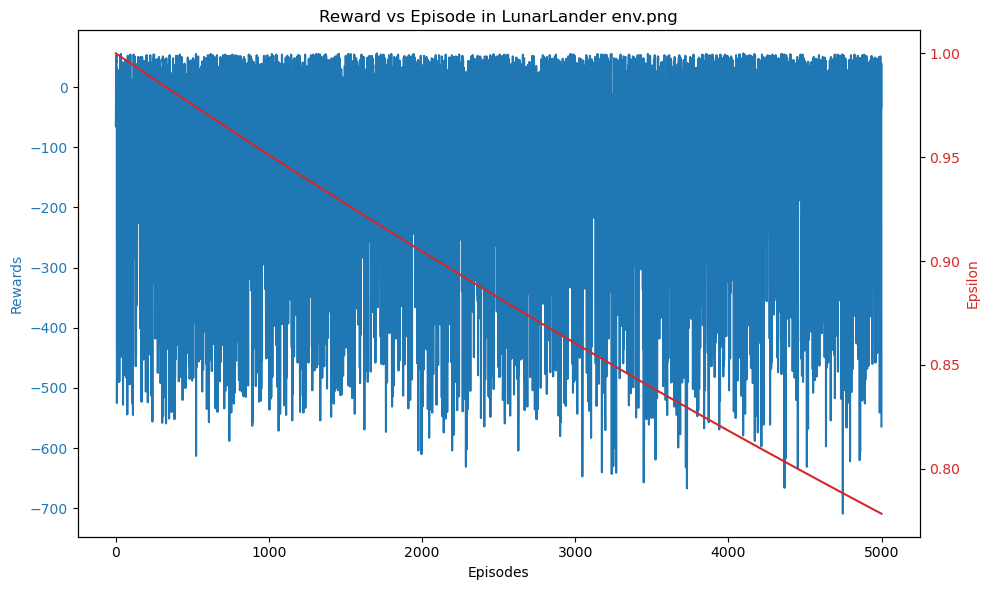

In [90]:
import random
from collections import deque, namedtuple
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gymnasium as gym
import moviepy.editor as mpy

class QNetwork(nn.Module):
    """Define Neural Network Architecture for Q-Learning"""

    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        """Map state to action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc4(x))
        return self.fc3(x)

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, batch_size, device):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

class Agent():
    """Interacts with and learns from the environment using DQN."""

    def __init__(self, state_size, action_size, seed, buffer_size, batch_size, gamma, tau, lr, update_every, device):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device
        self.gamma = gamma
        self.tau = tau
        self.update_every = update_every

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(self.device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)

        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
        self.batch_size = batch_size

        # Initialize time step (for updating every update_every steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory and use random sample from buffer to learn."""
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample(self.batch_size, self.device)
                self.learn(experiences)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        """Update value parameters using a batch of experience tuples."""
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values from target model for next states
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters."""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

def dqn(agent, env, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, decay_factor = 0.85, K = 100):
    """Deep Q-Learning."""
    scores = []
    epsilons = []
    eps = eps_start
    ct = 0
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        #frames = []
        for t in range(max_t):
            #frame = env.render(mode = 'rgb_array')
            #frames.append(frame)
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                #print("Terminated at step {}".format(t+1))
                ct += 1
                break
        scores.append(score)
        epsilons.append(eps)
        eps = epsilon_decay_function(eps_start, decay_factor, i_episode, K, eps_end)
        k = 250
        if i_episode % k == 0:
            print(f"Episode {i_episode}/{n_episodes}, Score: {np.mean(scores[-k:])}, Epsilon: {eps}")
            #frame_rate = 90  # Set the frame rate for the video
            #clip = mpy.ImageSequenceClip(frames, fps=frame_rate)
            #clip.write_videofile(f"Lunar_lander_trajectory_{i_episode}.mp4", codec="libx264")
    #print("Terminated on own: {}".format(ct))

    return scores , epsilons

# Initialize the environment and agent
env = LunarLander()
#env = gym.make('LunarLander-v2', continuous=False)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

agent = Agent(state_size=state_size, action_size=action_size, seed=0, buffer_size=100000, batch_size=64, gamma=0.99, tau=1e-3, lr=5e-4, update_every=4, device=device)

# Train the agent
scores , epsilons = dqn(agent, env, n_episodes=5000, eps_start=1.0, eps_end=0.005, decay_factor = 0.995, K = 100)
print("Average Reward per episode after 100 episdoes: {}".format(sum(scores[-100:]) / 100))

plot_metrics(scores , epsilons , title = "Reward vs Episode in LunarLander env.png")

In [5]:
def epsilon_decay_function(epsilon_start, decay_factor, episode, K, epsilon_end=0.1):
    return max(epsilon_start * (decay_factor ** (episode / K)), epsilon_end)

[-86, -287, 2, -15, 45, -117, -76, -384, -220, -531, 48, -553, -168, -142, 42, -57, -2, -295, -308, 15, -390, -522, -118, -279, 50, 41, 31, -282, -24, 40, 46, -551, -485, 33, -448, 34, 37, -186, 50, -36, -496, -180, -560, 52, -140, -540, -357, -5, 46, 10, 41, -96, -176, -469, 35, 44, 48, 23, 49, -155, -57, -30, -552, -313, 13, -66, 45, -2, 40, 45, -156, 43, -262, -166, -135, -12, 34, -518, -561, -252, 5, 24, 54, 42, -348, -563, 40, 22, -447, -1, -306, -400, -150, 29, -237, -500, -172, -50, -31, 46]
The average score is: -146.79


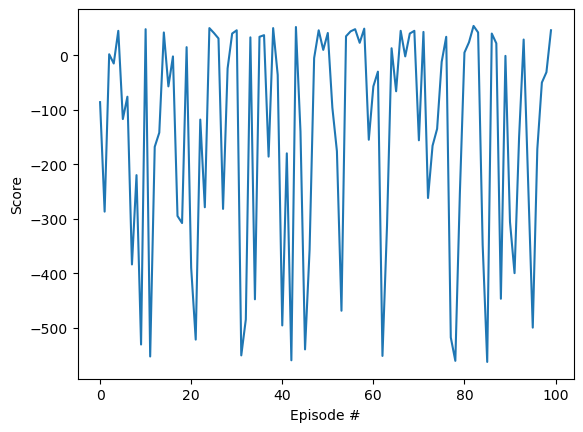

In [47]:
def random_Agent(env, n_episodes=100, max_t=1000):
    """Random Agent on Lunar Lander"""
    scores = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        frames = []
        for t in range(max_t):
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            score += reward
            if done:
                break
        scores.append(score)

    return scores
random_agent_scores = random_Agent(env)
print(random_agent_scores)
print("The average score is: {}".format(sum(random_agent_scores) / len(random_agent_scores)))

plt.plot(np.arange(len(random_agent_scores)), random_agent_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# DQN Agent on TreasureHunt-v2 (Discrete large state space)

In [6]:
class TreasureHunt_v2:

    def __init__(self, num_treasures = 2, num_pirates = 2, num_lands = 10, locations = None):

        #save the args 
        self.num_lands = num_lands
        self.num_pirates = num_pirates
        self.num_treasures = num_treasures
        #self.action_space = 4
        self.action_space = spaces.Discrete(4)

        if(locations is None):
            locations = dict()
            loc = self.sample_random_locations(self.num_treasures, self.num_pirates, self.num_lands)
            locations['treasure'] = loc[:self.num_treasures]
            locations['pirate'] = loc[self.num_treasures: self.num_treasures + self.num_pirates]
            locations['land'] = loc[self.num_pirates + self.num_treasures : ]
            locations['ship'] = [(0,0)]
            locations['fort'] = [(9,9)]

        #make the grid for the pirate and land
        self.land_spatial_state = np.zeros((10,10))
        for x,y in locations['land']:
            self.land_spatial_state[x,y] = 1
        self.pirate_spatial_state = np.zeros((10,10))
        for x,y in locations['pirate']:
            self.pirate_spatial_state[x,y] = 1

        #get the model
        self.env = TreasureHunt(locations)
        self.state = self.index_to_spatial(self.env.state)
    
    def render(self, state, path = 'state.jpeg', return_image = True):

        state_id = self.spatial_to_index(state) 
        image = self.env.render(state_id, path, return_image)
        if(return_image):
            return image 
    
    def visualize_policy_execution(self, policy, path = 'output.gif'):
        self.env.visualize_policy_execution(policy, path)

    def visualize_policy(self, policy, path = 'policy_vis.png'):
        self.env.visualize_policy(policy, path)

    def spatial_to_index(self, state):
        treasure_indicator = []
        for (x,y) in self.env.locations['treasure']:
            if(state[2,x,y] == 1):
                treasure_indicator.append('1')
            else:
                treasure_indicator.append('0')
        treasure_indicator = ''.join(treasure_indicator)
        index = self.env.index_from_treasure[treasure_indicator]
        index = 100*index + np.argmax(state[3])
        return index 

    def reset(self):

        loc = self.sample_random_locations(self.num_treasures, self.num_pirates, self.num_lands)
        locations = dict()
        locations['ship'] = [(0,0)]
        locations['fort'] = [(9,9)]
        locations['treasure'] = loc[:self.num_treasures]
        locations['pirate'] = loc[self.num_treasures: self.num_treasures + self.num_pirates]
        locations['land'] = loc[self.num_pirates + self.num_treasures : ]

        #make the grid for the pirate and land
        self.land_spatial_state = np.zeros((10,10))
        for x,y in locations['land']:
            self.land_spatial_state[x,y] = 1
        self.pirate_spatial_state = np.zeros((10,10))
        for x,y in locations['pirate']:
            self.pirate_spatial_state[x,y] = 1

        self.env = TreasureHunt(locations)
        self.env.reset()
        self.state = self.index_to_spatial(self.env.state)
        return self.state

    def index_to_spatial(self, index):
        ship_location, treasure_locations = self.env.locations_from_state(index)
        spatial_state = np.zeros((4, 10, 10))
        spatial_state[0] = self.land_spatial_state
        spatial_state[1] = self.pirate_spatial_state
        for (x,y) in treasure_locations:
            spatial_state[2,x,y] = 1
        spatial_state[3,ship_location[0], ship_location[1]] = 1
        return spatial_state > 0
    
    def step(self, action):

        nstate_id, r = self.env.step(action)
        self.state = self.index_to_spatial(self.env.state)
        return self.state, r 

    def get_policy_rewards(self, policy):
        return self.env.get_policy_rewards(policy)


    def sample_random_locations(self, num_treasures, num_pirates, num_lands):
        
        locations = [] 
        possible_locations = np.arange(1,99).tolist()
        locations_id = np.random.choice(possible_locations, num_treasures, replace = False).tolist()
        locations += locations_id   

        possible_locations = list(set(possible_locations) - set(locations_id))
        locations_id = np.random.choice(possible_locations, num_pirates, replace = False).tolist()
        locations += locations_id   
        
        possible_locations = list(set(possible_locations) - set(locations_id))
        locations_id = np.random.choice(possible_locations, num_lands, replace = False).tolist()
        locations += locations_id  

        loc = []
        for i in locations:
            loc.append((i // 10, i % 10))
        return loc
    
    def get_all_states(self):

        states = []
        for i in range(self.env.num_states):
            states.append(self.index_to_spatial(i))
        return np.stack(states, axis = 0)

In [15]:
#from env import TreasureHunt_v2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch 
import torch.nn as nn
import random 
import os 
#import wandb
#wandb.init(mode="offline", project="treasurehuntv2_qdn")

class CacheData:

    def __init__(self, cache_capacity = 100000):
        self.cache_capacity = cache_capacity
        self.data = []
        
    
    def add_item(self, item):
        if len(self.data) >= self.cache_capacity:
            self.data.pop(0)
        self.data.append(item)

    def sample_batch(self, batch_size):
    
        batch = random.sample(self.data, batch_size)
        states = np.stack([experience[0] for experience in batch])
        actions = np.array([experience[1] for experience in batch])
        rewards = np.array([experience[2] for experience in batch])
        next_states = np.stack([experience[3] for experience in batch])
        #dones = np.array([experience[4] for experience in batch])

        return states, actions, rewards, next_states


class QNetwork(nn.Module):
    def __init__(self, input_channels=4, num_actions=4, H=10, W=10):
        super(QNetwork, self).__init__()      
        self.conv1 = nn.Conv2d(4, 64, (3,3), 1, 1)
        self.conv2 = nn.Conv2d(64, 64, (3,3), padding = 1, stride = 2)
        self.conv3 = nn.Conv2d(64, 64, (3,3), padding = 1, stride = 2)
        
        self.fc1 = nn.Linear( 576 , 64)
        self.fc2 = nn.Linear(64, 4)
        self.relu = nn.ReLU()

    def forward(self, x, actions = None):

        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.flatten(1,-1)
        x = self.fc2(self.relu(self.fc1(x)))
        return x 
    
class DeepQAgent:

    def __init__(self, env, demo_env, cache_size = 100000):

        self.env = env 
        self.dataset = CacheData(cache_size)
        self.qnetwork = QNetwork()
        self.optimizer = torch.optim.Adam(self.qnetwork.parameters(), lr = 0.00005)
        
        #TO VALIDATE
        self.demo_env = demo_env

    def get_policy(self, states):
        states = torch.tensor(states).float()
        qsa = self.qnetwork(states)
        qsa = qsa.argmax(dim = -1)
        qsa = torch.nn.functional.one_hot(qsa)
        policy = qsa.numpy()
        return policy

    def visualize_policy(self, itr, path = './treasurehunt_v2_dqn/'):
        os.makedirs(path, exist_ok = True)
        for i, e in enumerate(self.demo_env[:5]):
            states = e.get_all_states()
            policy = self.get_policy(states)
            path_ = os.path.join(path, f'visualize_policy_{i}_{itr}.png')
            e.visualize_policy(policy, path_)

            path_ = os.path.join(path, f'visualize_policy_{i}_{itr}.gif')
            e.visualize_policy_execution(policy, path_)

    def validate(self, num_episodes=10):
        total_rewards = []
        for _ in range(num_episodes):
            state = self.env.reset()
            episode_reward = 0
            done = False
            while not done:
                action = self.qnetwork(torch.tensor(state).float()).argmax().item()
                next_state, reward = self.env.step(action)
                episode_reward += reward
                state = next_state
                if self.env.is_done():
                    done = True
            total_rewards.append(episode_reward)
        return np.mean(total_rewards)
        

    def choose_action(self, state, epsilon=0.1):
        if random.random() < epsilon:
            # Exploration: choose a random action
            return self.env.action_space.sample()
        else:
            # Exploitation: choose action with highest Q-value
            state_tensor = torch.tensor(state).float().unsqueeze(0)  # Add batch dimension
            with torch.no_grad():
                q_values = self.qnetwork(state_tensor)
            return q_values.argmax().item()  # Return action with max Q-value


    def learn_policy(self, itrs = 50):
        
        losses = []
        for i in tqdm(range(1, itrs)):
            state = self.env.reset()
            
            #add episode to the buffer
            for j in range(100):

                action = self.choose_action(state)
                next_state_, reward = self.env.step(action)
                self.dataset.add_item((state, action, next_state_, reward))
                state = next_state_

            
                state, action, next_state, reward = self.dataset.sample_batch(64)
                state_batch = torch.tensor(state).float()
                action_batch = torch.tensor(action).long().unsqueeze(1)
                next_state_batch = torch.tensor(next_state).float()
                reward_batch = torch.tensor(reward).float()

                q_values = self.qnetwork(state_batch).gather(1, action_batch) 

                with torch.no_grad():
                    max_next_q_values = self.qnetwork(next_state_batch).max(dim=1)[0].unsqueeze(1)
                    target_q_values = reward_batch.unsqueeze(1) + (0.99 * max_next_q_values)

                loss = torch.nn.functional.mse_loss(q_values, target_q_values)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())

                #EPSILON DECAY STEP
                eps = epsilon_decay_function(epsilon_start = 1.0, decay_factor = 0.9999, episode = i , K = 100, epsilon_end = 0.005)
                print(j)

                if j % 10 == 0:
                    print("Go Deeper")
                    self.visualize_policy(i)
                    #demo_values = self.qnetwork(self.demo_state).max().item()
                    rewards = self.validate()
                    #wandb.log({'rewards': rewards, "steps": i})
                    print(f"loss: {sum(losses)/len(losses)}  reward: {rewards} eps: {self.eps} buffer reward: {self.dataset.average_reward()}")
                    losses = []



demo_envs = []
for i in range(100):
    demo_envs.append(TreasureHunt_v2())    
env = TreasureHunt_v2()
qagent = DeepQAgent(env, demo_envs)
qagent.learn_policy()


  0%|                                                    | 0/49 [00:00<?, ?it/s]


ValueError: Sample larger than population or is negative

In [20]:
conv_output_size = 64 * (10 // 4) * (10 // 4)
print(conv_output_size)

256
